In [1]:
# importing libraries

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import joblib

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
# Changing values to be suitable for our model

df["HeartDisease"] = df["HeartDisease"].replace(["No", "Yes"], [0, 1])
df["Smoking"] = df["Smoking"].replace(["No", "Yes"], [0, 1])
df["AlcoholDrinking"] = df["AlcoholDrinking"].replace(["No", "Yes"], [0, 1])
df["Stroke"] = df["Stroke"].replace(["No", "Yes"], [0, 1])
df["DiffWalking"] = df["DiffWalking"].replace(["No", "Yes"], [0, 1])
df["PhysicalActivity"] = df["PhysicalActivity"].replace(["No", "Yes"], [0, 1])
df["Asthma"] = df["Asthma"].replace(["No", "Yes"], [0, 1])
df["KidneyDisease"] = df["KidneyDisease"].replace(["No", "Yes"], [0, 1])
df["SkinCancer"] = df["SkinCancer"].replace(["No", "Yes"], [0, 1])
df["Diabetic"] = df["Diabetic"].replace(["No", "No, borderline diabetes", "Yes", "Yes (during pregnancy)"], [0, 0, 1, 1])

df["Sex"] = df["Sex"].replace(["Female", "Male"], [0, 1])
races = ["Other", "White", "American Indian/Alaskan Native", "Hispanic", "Asian", "Black"]
races_as_numbers = [0, 0.2, 0.4, 0.6, 0.8, 1]
df["Race"] = df["Race"].replace(races, races_as_numbers)
general_health_markers = ["Poor", "Fair", "Excellent", "Good", "Very good"]
general_health_markers_as_numbers = [0, 0.25, 0.5, 0.75, 1]
df["GenHealth"] = df["GenHealth"].replace(general_health_markers, general_health_markers_as_numbers)
age_categories = list(df["AgeCategory"].value_counts().index)
age_categories.sort()
len_age_categories = len(age_categories)
# The list below will end up having values from 0 to 1, with the same distance between each other
age_categories_as_numbers = [(1 / (len_age_categories - 1)) * idx for idx in range(len_age_categories)]
df["AgeCategory"] = df["AgeCategory"].replace(age_categories, age_categories_as_numbers)

df["BMI"] = df["BMI"].astype("int")

In [4]:
# The dataset is inbalanced (9% positive for HeartDisease and 91% negative for HeartDisease)
# In order to balance it we'll compare different amounts of undersampling and pick the best one
# Since we want the model to be really good at finding positive cases, the most important metric for it will be recall, followed closely by precision

def undersample_dataset(dataframe, y_column, percentage_removed):
    """
    Returns dataframe with some of the rows where y_column has the value 0 removed
    The amount of rows removed is determined by percentage_removed
    """
    
    rows_with_target_variable_0 = dataframe[dataframe[y_column] == 0]
    len_rows_with_target_variable_0 = len(rows_with_target_variable_0)
    
    new_dataframe = rows_with_target_variable_0[int(len_rows_with_target_variable_0 * (percentage_removed / 100)):]
    new_dataframe = dataframe[dataframe[y_column] == 1].append(new_dataframe)
    
    return new_dataframe

def compute_decisiontreeclassifier_metrics(X_train, X_test, y_train, y_test, repetions=10):
    acc = 0
    prec = 0
    recall = 0
    f1 = 0
    for _ in range(repetions):
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc += metrics.accuracy_score(y_test, y_pred)
        # There can be 0 positive predictions, so we set zero_divison=0 to avoid any errors
        prec += metrics.precision_score(y_test, y_pred, zero_division = 0)
        recall += metrics.recall_score(y_test, y_pred)
        f1 += metrics.f1_score(y_test, y_pred)
    
    acc /= repetions
    prec /= repetions
    recall /= repetions
    f1 /= repetions
    
    return acc, prec, recall, f1

result = pd.DataFrame(columns=["acc", "prec", "recall", "f1", "items_left"])
list_of_percentages = [90, 75, 50, 25, 10, 1]
for percentage_removed in list_of_percentages:
    print(f"Iteration {list_of_percentages.index(percentage_removed) + 1}/{len(list_of_percentages)}")
    new_df = undersample_dataset(df, "HeartDisease", percentage_removed)
    
    X = new_df.drop("HeartDisease", axis=1)
    y = new_df["HeartDisease"]
    
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)
    
    scores = compute_decisiontreeclassifier_metrics(X_train, X_test, y_train, y_test)
    
    row_name = str(percentage_removed)
    
    result.loc[row_name] = list(scores) + [len(X)]

print(result)
# Removing 90% of the negative results gives us the best recall, while the accuracy doesn't take too big of a hit
# The items left in our dataset after the removal are 27.4k positive results and 29.2k negative results, which seem numerous enough to have an accurate model

Iteration 1/6
Iteration 2/6
Iteration 3/6
Iteration 4/6
Iteration 5/6
Iteration 6/6
         acc      prec    recall        f1  items_left
90  0.679124  0.677784  0.656181  0.666806     56616.0
75  0.726025  0.495425  0.494153  0.494787    100479.0
50  0.798776  0.363178  0.353063  0.358048    173584.0
25  0.843853  0.283563  0.282445  0.283001    246690.0
10  0.861436  0.264784  0.260574  0.262661    290553.0
1   0.870274  0.244339  0.237473  0.240855    316871.0


<AxesSubplot:>

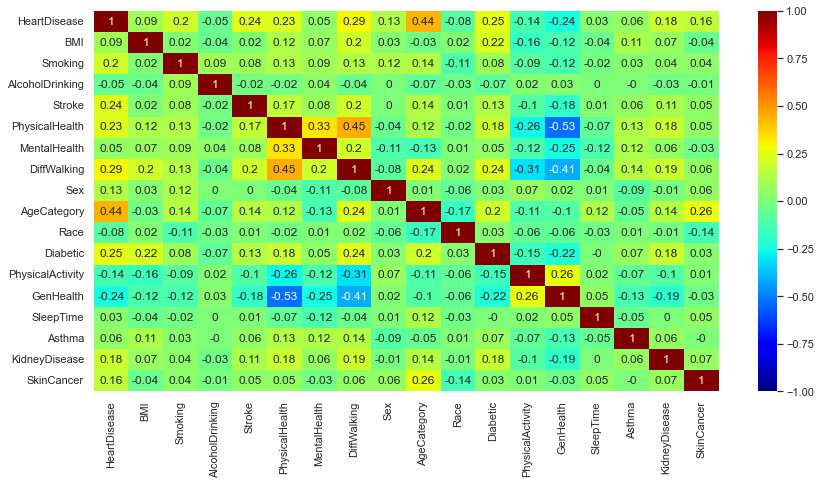

In [5]:
# Seeing which features correlate with "HeartDisease" the most(first column)
# These will be used in our machine learning model, while the others will be discarded

new_df = undersample_dataset(df, "HeartDisease", 90)
sns.set(rc = {'figure.figsize':(14,7)})
sns.heatmap(new_df.corr().round(2), annot=True, cmap='jet', vmin=-1, vmax=1)

In [6]:
# Now we will check how many features we can add to our model to get the best recall and precision

new_df = undersample_dataset(df, "HeartDisease", 90)
# Stores the correlation between every feature and HeartDisease (first column from our heatmap) in descending order of absolute value
corr_to_heartdisease = pd.Series(new_df.corr().round(2).iloc[:,0]).drop("HeartDisease").abs()
corr_to_heartdisease = corr_to_heartdisease.sort_values(ascending=False)

X = pd.DataFrame()
y = new_df["HeartDisease"]
result = pd.DataFrame(columns=["acc", "prec", "recall", "f1"])
for index in corr_to_heartdisease.index:
    X[index] = new_df[index]
    print(f"Iteration {len(X.columns)}/{len(corr_to_heartdisease.index)}")

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)
    
    scores = compute_decisiontreeclassifier_metrics(X_train, X_test, y_train, y_test)
    
    row_name = ""
    for column in X.columns:
        row_name += column[:3] + ","
    row_name = row_name[:-1]
    
    result.loc[row_name] = scores

print(result)
# Recall is at it's highest with one feature. However accuracy, precision and f1 are at their highest with 5:
#                                                          acc      prec  recall        f1  
# Age                                                 0.686242  0.639337  0.799376  0.710456  
# Age,Dif                                             0.712292  0.676818  0.787134  0.727820  
# Age,Dif,Dia                                         0.714324  0.693472  0.740156  0.716054  
# Age,Dif,Dia,Str                                     0.727746  0.696744  0.771596  0.732262  
# Age,Dif,Dia,Str,Gen                                 0.747430  0.728041  0.768450  0.747700  
# Age,Dif,Dia,Str,Gen,Phy                             0.730334  0.712100  0.739307  0.725448  
# Age,Dif,Dia,Str,Gen,Phy,Smo                         0.734943  0.729179  0.725041  0.727104   
#
# because of that the final model will contain 5 features: AgeCategory, DiffWalking, Diabetic, Stroke, GenHealth

Iteration 1/17
Iteration 2/17
Iteration 3/17
Iteration 4/17
Iteration 5/17
Iteration 6/17
Iteration 7/17
Iteration 8/17
Iteration 9/17
Iteration 10/17
Iteration 11/17
Iteration 12/17
Iteration 13/17
Iteration 14/17
Iteration 15/17
Iteration 16/17
Iteration 17/17
                                                         acc      prec  \
Age                                                 0.688361  0.644691   
Age,Dif                                             0.715472  0.680880   
Age,Dif,Dia                                         0.722271  0.697404   
Age,Dif,Dia,Str                                     0.727481  0.699112   
Age,Dif,Dia,Str,Gen                                 0.748764  0.724225   
Age,Dif,Dia,Str,Gen,Phy                             0.734520  0.719150   
Age,Dif,Dia,Str,Gen,Phy,Smo                         0.728471  0.710139   
Age,Dif,Dia,Str,Gen,Phy,Smo,Kid                     0.726554  0.715665   
Age,Dif,Dia,Str,Gen,Phy,Smo,Kid,Ski                 0.716213  0.715377 

In [7]:
# Final model (DecisionTreeClassifier)

new_df = undersample_dataset(df, "HeartDisease", 90)
X = new_df[["AgeCategory", "DiffWalking", "Diabetic", "Stroke", "GenHealth"]]
y = new_df["HeartDisease"]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print("acc:", acc)
print("prec:", prec)
print("recall:", recall)
print("f1:", f1)

joblib.dump(model, "./temp_model/temp_model.joblib")

acc: 0.746026139173437
prec: 0.7257034351803902
recall: 0.7656164633035877
f1: 0.7451258419000356


['./temp_model/temp_model.joblib']

In [8]:
# Importing final model

model = joblib.load("./actual_model/actual_model.joblib")